In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt

In [3]:
observation_date = observation_date = dt.datetime(year=2021, month=2, day=27)

FILE_NAMES = [
    "data/{td:%y}-{td:%m}-{td:%d}-ohlc".format(td=observation_date)
    ,
]

In [4]:
## TODO: Make this actually work for multiple files
for file in FILE_NAMES:
    with open(file, 'rb') as f:
        data = np.frombuffer(f.read()).reshape(-1, 5).copy()
        data[:,0] = list(map(lambda dtbytes: int.from_bytes(dtbytes, 'little'),data[:,0]))

In [5]:
df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)

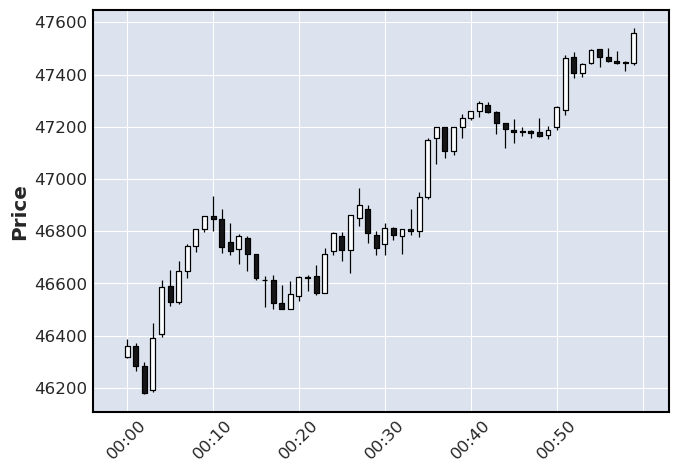

In [6]:
mpf.plot(df.set_index('timestamp')[:60], type='candle')

In [7]:
# Reshape into 4 channel timeseries
# Channels 0,1,2,3 = open, high, low, close
series = data.T[1:].reshape(4,1440)

# Normalize series between [0,1] (MinMaxScaler)
normed_series = np.empty(shape=(4,1440))
for idx, channel in enumerate(series):
    min_ = np.min(channel)
    max_ = np.max(channel)
    normed_channel = (channel - min_) / (max_ - min_)
    normed_series[idx] = normed_channel

sample = normed_series.T[:60].T

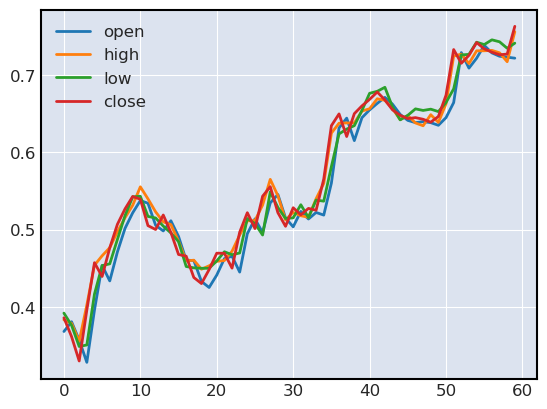

In [8]:
plt.plot(np.arange(0, len(sample[0])), sample[0], label="open")
plt.plot(np.arange(0, len(sample[1])), sample[1], label="high")
plt.plot(np.arange(0, len(sample[2])), sample[2], label="low")
plt.plot(np.arange(0, len(sample[3])), sample[3], label="close")
plt.legend()

When converting timeseries to 2d space, it may be tempting to just encode each value in the sequence to a 2d representation [value, index] where index is some number derived from a linear space (sequence?) and represents the value's position in the sequence. This works, but you can see that the magnitude of the vectors is heavily skewed towards one end of the sequence, regardless of the value at that point in the sequence, which would affect results from matrix and vector operations that you may use to "query" this new 2d space

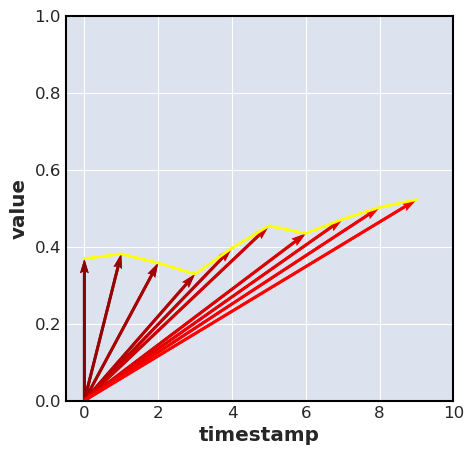

In [42]:
from matplotlib.colors import to_rgba 
origin = [0,0]
X, Y = zip(origin, origin)
data = np.array([0, sample[0][0]])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(10):
    vec = np.array([i, sample[0][i]])
    ax.quiver(X, Y, *vec, angles='xy', scale_units='xy', scale=1, color=(.5 + .05*(i+1),0.,0.))
    
ax.plot(np.arange(0,10), sample[0][:10], color="yellow")
ax.set_xlabel("timestamp")
ax.set_ylabel("value")
ax.set_xlim(-0.5,10)
_ =ax.set_ylim(0, 1)

In [16]:
polar_sample = np.arccos(sample.T).T
r = np.linspace(0, 1, 61, endpoint=True)[1:]  # Don't use np.arange for this

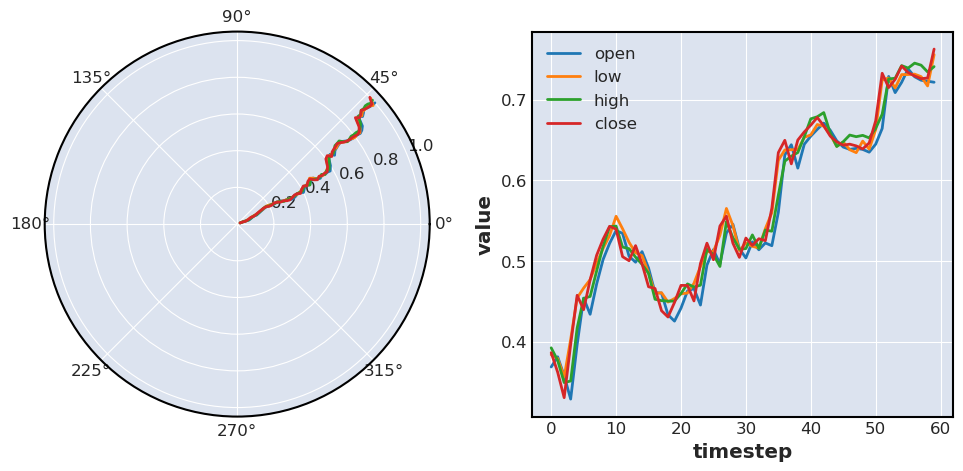

In [17]:
channels = ["open", "low", "high", "close"]
fig = plt.figure(figsize=(25,5))
axp = fig.add_subplot(141, projection='polar')
axc = fig.add_subplot(142, projection='rectilinear')
for idx, chan in enumerate(channels):
    axp.plot(sample[idx], r, label=chan)
    axc.plot(np.arange(0, len(sample[idx])), sample[idx], label=chan)
axc.set_xlabel("timestep")
axc.set_ylabel('value')
plt.legend()
plt.show()

In [18]:
gasf = lambda theta1, theta2: np.cos(theta1 + theta2)

In [19]:
gramian = np.empty((*polar_sample.shape, polar_sample.shape[-1]))

In [20]:
# TODO: Leverage symmetry here to reduce computation count
for channel in range(len(channels)):
    for idx, theta in enumerate(polar_sample[channel]):
        for idx_, theta_ in enumerate(polar_sample[channel]):
            res = gasf(theta,theta_)
            gramian[channel][idx][idx_] = res
        

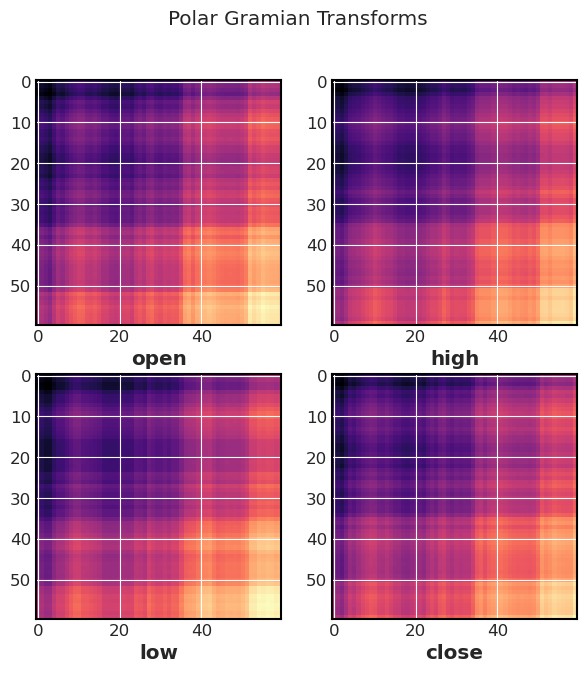

In [21]:
fig = plt.figure(figsize=(7,7))
ax_open = fig.add_subplot(221)
ax_open.imshow(gramian[0], cmap='magma')
ax_open.set_xlabel("open")
ax_high= fig.add_subplot(222)
ax_high.imshow(gramian[1], cmap='magma')
ax_high.set_xlabel("high")
ax_low = fig.add_subplot(223)
ax_low.imshow(gramian[2], cmap='magma')
ax_low.set_xlabel("low")
ax_close = fig.add_subplot(224)
ax_close.imshow(gramian[3], cmap='magma')
ax_close.set_xlabel("close")
fig.suptitle("Polar Gramian Transforms")
fig.show()

In [25]:
## WARNING: I AM NOT SURE THAT ANYTHING BELOW THIS COMMENT IS CORRECT
# Recurrence Plot
gasf_rectilinear = lambda x, y: np.dot(x.T, y) - np.dot(np.sqrt(np.ones(x.shape) - x**2).T   ## [1,1]
                                                        , np.sqrt(np.ones(y.shape) - y**2)) 
gramian_rectilinear = np.empty((*sample.shape, sample.shape[-1]))

In [26]:
for channel in range(len(channels)):
    for idx, val in enumerate(sample[channel]):
        for idx_, val_ in enumerate(sample[channel]):
            res = gasf_rectilinear(val,val_)
            gramian_rectilinear[channel][idx][idx_] = res

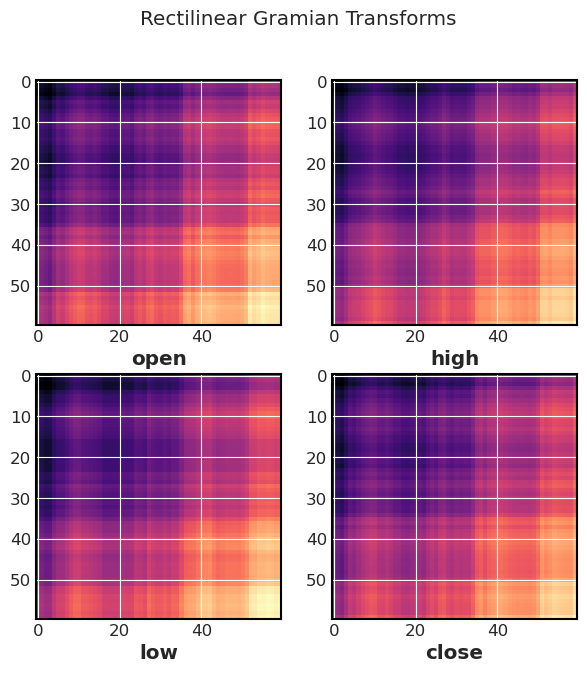

In [24]:
fig = plt.figure(figsize=(7,7))
ax_open = fig.add_subplot(221)
ax_open.imshow(gramian_rectilinear[0], cmap='magma')
ax_open.set_xlabel("open")
ax_high= fig.add_subplot(222)
ax_high.imshow(gramian_rectilinear[1], cmap='magma')
ax_high.set_xlabel("high")
ax_low = fig.add_subplot(223)
ax_low.imshow(gramian_rectilinear[2], cmap='magma')
ax_low.set_xlabel("low")
ax_close = fig.add_subplot(224)
ax_close.imshow(gramian_rectilinear[3], cmap='magma')
ax_close.set_xlabel("close")
fig.suptitle("Rectilinear Gramian Transforms")
fig.show()

In [28]:
## CULR approach (reference https://arxiv.org/pdf/1901.05237.pdf)
## I'm not exactly sure how they calcualte the upper shadow, real body, and lower shadow. I'll try with just the difference
# 0 -> Open 1-> High 2-> Low 3 -> Close
series_culr = np.empty(series.shape)
series_culr[0] = series[3]  # Close
series_culr[1] = series[1]  - np.maximum(series[0], series[3])  # Not sure if this is right. Can't tell how they
                                                                # are using the real body for this calc. This is an 
                                                                # attempt at computing the upper shadow.
        
series_culr[2] = np.minimum(series[0], series[3]) - series[2]        # Not sure what the order should be here
series_culr[3] = series[0] - series[3]                               # open-close or close-open?

In [29]:
normed_series_culr = np.empty(shape=(4,1440))
for idx, channel in enumerate(series_culr):
    min_ = np.min(channel)
    max_ = np.max(channel)
    normed_channel = (channel - min_) / (max_ - min_)
    normed_series_culr[idx] = normed_channel

In [30]:
culr_sample_polar = np.arccos(normed_series_culr.T[:60]).T
r = np.linspace(0, 1, 61, endpoint=True)[1:]

In [31]:
gramian_culr = np.empty((*culr_sample_polar.shape, culr_sample_polar.shape[-1]))
channels = ["close", "upper_shadow", "lower_shadow", "real_body"]

In [32]:
for channel in range(len(channels)):
    for idx, theta in enumerate(culr_sample_polar[channel]):
        for idx_, theta_ in enumerate(culr_sample_polar[channel]):
            res = gasf(theta,theta_)
            gramian_culr[channel][idx][idx_] = res

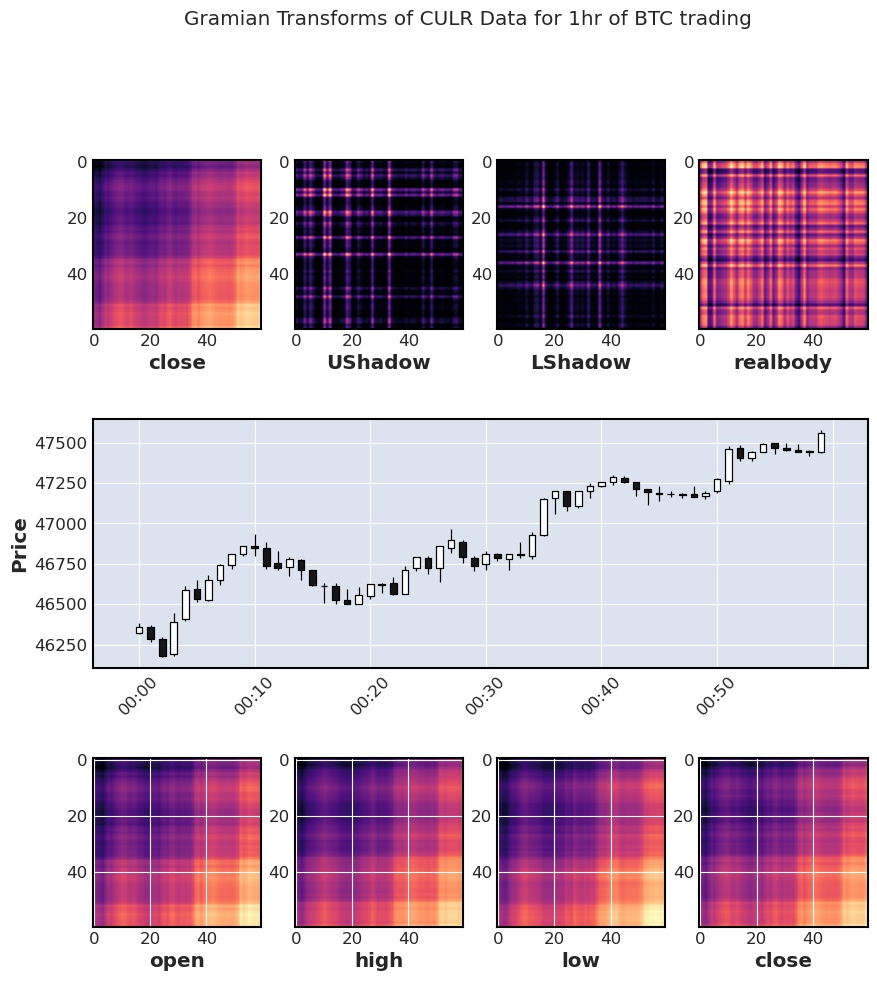

In [33]:
fig = plt.figure(figsize=(10,11))
gs = fig.add_gridspec(3,4)
ax_close = fig.add_subplot(gs[0,0])
ax_close.imshow(gramian_culr[0], cmap='magma')
ax_close.set_xlabel("close")
ax_close.grid(False)
ax_uppershadow= fig.add_subplot(gs[0,1])
ax_uppershadow.imshow(gramian_culr[1], cmap='magma')
ax_uppershadow.set_xlabel("UShadow")
ax_uppershadow.grid(False)
ax_lowershadow = fig.add_subplot(gs[0,2])
ax_lowershadow.imshow(gramian_culr[2], cmap='magma')
ax_lowershadow.set_xlabel("LShadow")
ax_lowershadow.grid(False)
ax_realbody = fig.add_subplot(gs[0,3])
ax_realbody.imshow(gramian_culr[3], cmap='magma')
ax_realbody.set_xlabel("realbody")
ax_realbody.grid(False)

ax_candle = fig.add_subplot(gs[1, :])
mpf.plot(df.set_index('timestamp')[:60], type='candle', ax=ax_candle)

ax_open = fig.add_subplot(gs[2,0])
ax_open.imshow(gramian[0], cmap='magma')
ax_open.set_xlabel("open")
ax_high= fig.add_subplot(gs[2,1])
ax_high.imshow(gramian[1], cmap='magma')
ax_high.set_xlabel("high")
ax_low = fig.add_subplot(gs[2,2])
ax_low.imshow(gramian[2], cmap='magma')
ax_low.set_xlabel("low")
ax_close_2 = fig.add_subplot(gs[2,3])
ax_close_2.imshow(gramian[3], cmap='magma')
ax_close_2.set_xlabel("close")
fig.suptitle("Polar Gramian Transforms")
fig.suptitle("Gramian Transforms of CULR Data for 1hr of BTC trading")

fig.show()

In [ ]:
culr_sample_polar.shape

In [ ]:
## TODO: Test out https://github.com/johannfaouzi/pyts/blob/master/pyts/image/gaf.py